<a href="https://colab.research.google.com/github/nathaliaferino/PIBIC---AN-OVERVIEW-OF-THE-USE-OF-ARTIFICIAL-NEURAL-NETWORKS-IN-QUANTUM-INFORMATION/blob/main/RNA_TREINAMENTO_COM_ESTADOS_MISTOS_SEPAR%C3%81VEIS_E_EMARANHADOS_COM_NEGATIVIDADE_NO_INTERVALO_(0_2%2C_0_3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Rede Neural Artificial adaptada de:** UREÑA, Julio, et al. Entanglement detection with classical deep neural networks. Scientific Reports, 2024, 14.1: 18109.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import math
import random
from google.colab import files
from torch.utils.data import DataLoader, TensorDataset

Mounted at /content/drive


In [ ]:
# Dados de para treino da RNA
# Leitura dos dados
treino_sep = pd.read_csv('/content/drive/MyDrive/GITHUB/Detecção de Emaranhamento Quântico/ESTADOS MISTOS/TREINO/TREINO_MISTO_SEPARAVEL.csv', header=None).to_numpy()
treino_ema = pd.read_csv('/content/drive/MyDrive/GITHUB/Detecção de Emaranhamento Quântico/ESTADOS MISTOS/TREINO/TREINO_MISTO_NEG_0.2_0.3.csv', header=None).to_numpy()

# Estados separáveis: 0, Estados máximamente emaranhados: 1
indice_zero = np.zeros((len(treino_sep), 1))
indice_one = np.ones((len(treino_ema), 1))
treino_sep = np.hstack((treino_sep, indice_zero))
treino_ema = np.hstack((treino_ema, indice_one))

# Embaralhando os dados
treino = np.vstack((treino_sep, treino_ema))
np.random.shuffle(treino)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Estrutura da RNA
class RNA_emaranhamento(nn.Module):
    def __init__(self):
        super(RNA_emaranhamento, self).__init__()

        # Camada de entrada
        self.linear0 = nn.Linear(16, 800)

        # Camadas ocultas
        self.linear11 = nn.Linear(800,512)
        self.linear1 = nn.Linear(512,256)
        self.linear2 = nn.Linear(256,128)
        self.linear3 = nn.Linear(128,16)

        # Camada de saída
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        #Camada de entrada
        x = self.linear0(x)

        # Camadas ocultas com ReLU
        x = F.relu(self.linear11(x))
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))

        # Camada de saída com sigmoide
        y_predicted = torch.sigmoid(self.output(x))
        return y_predicted

#Otimizador e função custo
model = RNA_emaranhamento().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.NAdam(
    model.parameters(),
    lr=0.001,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    momentum_decay=4e-3
)

In [ ]:
x = treino[:, :16]
y = treino[:, 16].reshape(-1, 1)

# Normalização dos valores de entrada
mean = np.mean(x, axis=0, keepdims=True)
std  = np.std(x, axis=0, keepdims=True)
std = np.where(std < 1e-12, 1e-12, std)
x = (x - mean) / std

# Conversão para tensor
x = torch.from_numpy(x).float().to(device)
y = torch.from_numpy(y).float().to(device)

# Separando os dados em lotes
tamanho_do_lote = 100
dataset = TensorDataset(x, y)
loader = DataLoader(dataset, batch_size=tamanho_do_lote, shuffle=True)
num_lotes = x.shape[0] // tamanho_do_lote

# Quantidade de iterações
num_epocas = 1000

# Perda
losses = []

# Treinamento
model.train()
for epoca in range(num_epocas):

    epoch_loss = 0.0

    for x_lote, y_lote in loader:
        # Forward
        y_pred = model(x_lote)

        # Loss
        loss = criterion(y_pred, y_lote)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # média da época
    epoch_loss /= len(loader)
    losses.append(epoch_loss)

    if (epoca + 1) % 100 == 0:
        print(f"Época [{epoca+1}/{num_epocas}], Loss: {epoch_loss:.6f}")

print("\nTreinamento concluído.")

Época [100/1000], Loss: 0.000000
Época [200/1000], Loss: 0.000000
Época [300/1000], Loss: 0.000000
Época [400/1000], Loss: 0.000000
Época [500/1000], Loss: 0.000000
Época [600/1000], Loss: 0.000000
Época [700/1000], Loss: 0.000000
Época [800/1000], Loss: 0.000000
Época [900/1000], Loss: 0.000000
Época [1000/1000], Loss: 0.000000

Treinamento concluído.


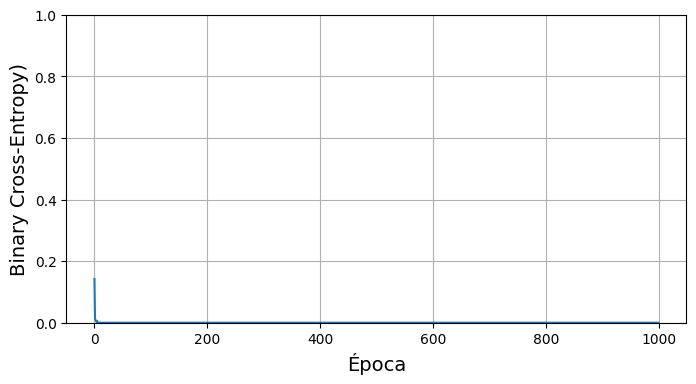

In [ ]:
# Velocidade de convergência da RNA
plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.xlabel('Época', fontsize=14)
plt.ylabel('Binary Cross-Entropy)', fontsize=14)
plt.grid(True)
plt.ylim(0.0, 1.0)
plt.show()

In [ ]:
# Ler dados para teste da RNA
Pteste_sep = pd.read_csv('/content/drive/MyDrive/GITHUB/Detecção de Emaranhamento Quântico/ESTADOS PUROS/TESTE/TESTE_PURO_SEPARAVEL.csv', header=None).to_numpy()
Pteste_emar_0_1 = pd.read_csv('/content/drive/MyDrive/GITHUB/Detecção de Emaranhamento Quântico/ESTADOS PUROS/TESTE/TESTE_PURO_NEG_0.0_0.1.csv', header=None).to_numpy()
Pteste_emar_1_2 = pd.read_csv('/content/drive/MyDrive/GITHUB/Detecção de Emaranhamento Quântico/ESTADOS PUROS/TESTE/TESTE_PURO_NEG_0.1_0.2.csv', header=None).to_numpy()
Pteste_emar_2_3 = pd.read_csv('/content/drive/MyDrive/GITHUB/Detecção de Emaranhamento Quântico/ESTADOS PUROS/TESTE/TESTE_PURO_NEG_0.2_0.3.csv', header=None).to_numpy()
Pteste_emar_3_4 = pd.read_csv('/content/drive/MyDrive/GITHUB/Detecção de Emaranhamento Quântico/ESTADOS PUROS/TESTE/TESTE_PURO_NEG_0.3_0.4.csv', header=None).to_numpy()
Pteste_emar_4_5 = pd.read_csv('/content/drive/MyDrive/GITHUB/Detecção de Emaranhamento Quântico/ESTADOS PUROS/TESTE/TESTE_PURO_NEG_0.4_0.5.csv', header=None).to_numpy()

Mteste_sep = pd.read_csv('/content/drive/MyDrive/GITHUB/Detecção de Emaranhamento Quântico/ESTADOS MISTOS/TESTE/TESTE_MISTO_SEPARAVEL.csv', header=None).to_numpy()
Mteste_emar_0_1 = pd.read_csv('/content/drive/MyDrive/GITHUB/Detecção de Emaranhamento Quântico/ESTADOS MISTOS/TESTE/TESTE_MISTO_NEG_0.0_0.1.csv', header=None).to_numpy()
Mteste_emar_1_2 = pd.read_csv('/content/drive/MyDrive/GITHUB/Detecção de Emaranhamento Quântico/ESTADOS MISTOS/TESTE/TESTE_MISTO_NEG_0.1_0.2.csv', header=None).to_numpy()
Mteste_emar_2_3 = pd.read_csv('/content/drive/MyDrive/GITHUB/Detecção de Emaranhamento Quântico/ESTADOS MISTOS/TESTE/TESTE_MISTO_NEG_0.2_0.3.csv', header=None).to_numpy()
Mteste_emar_3_4 = pd.read_csv('/content/drive/MyDrive/GITHUB/Detecção de Emaranhamento Quântico/ESTADOS MISTOS/TESTE/TESTE_MISTO_NEG_0.3_0.4.csv', header=None).to_numpy()
Mteste_emar_4_5 = pd.read_csv('/content/drive/MyDrive/GITHUB/Detecção de Emaranhamento Quântico/ESTADOS MISTOS/TESTE/TESTE_MISTO_NEG_0.4_0.5.csv', header=None).to_numpy()


def separar_conjuntos_de_testes(separavel,emaranhado):
  indice_zero = np.zeros((len(separavel), 1))
  indice_one = np.ones((len(emaranhado), 1))

  separavel = np.hstack((separavel, indice_zero))
  emaranhado = np.hstack((emaranhado, indice_one))

  dados_teste = np.vstack((separavel, emaranhado))
  np.random.shuffle(dados_teste)
  return dados_teste

Pnegatividade0_1 = separar_conjuntos_de_testes(Pteste_sep, Pteste_emar_0_1)
Pnegatividade1_2 = separar_conjuntos_de_testes(Pteste_sep, Pteste_emar_1_2)
Pnegatividade2_3 = separar_conjuntos_de_testes(Pteste_sep, Pteste_emar_2_3)
Pnegatividade3_4 = separar_conjuntos_de_testes(Pteste_sep, Pteste_emar_3_4)
Pnegatividade4_5 = separar_conjuntos_de_testes(Pteste_sep, Pteste_emar_4_5)

Mnegatividade0_1 = separar_conjuntos_de_testes(Mteste_sep, Mteste_emar_0_1)
Mnegatividade1_2 = separar_conjuntos_de_testes(Mteste_sep, Mteste_emar_1_2)
Mnegatividade2_3 = separar_conjuntos_de_testes(Mteste_sep, Mteste_emar_2_3)
Mnegatividade3_4 = separar_conjuntos_de_testes(Mteste_sep, Mteste_emar_3_4)
Mnegatividade4_5 = separar_conjuntos_de_testes(Mteste_sep, Mteste_emar_4_5)


In [ ]:
def calcular_taxa_acerto(dados, mean1, std1):
    # Separação entrada/saída
    x_teste = dados[:, :16]
    y_teste = dados[:, 16].reshape(-1, 1)

    # Normalização Z-score
    std_safe1 = np.where(std1 < 1e-12, 1e-12, std1)
    x_teste = (x_teste - mean1) / std_safe1

    # Converte para tensor
    x_teste = torch.from_numpy(x_teste).float().to(device)
    y_teste = torch.from_numpy(y_teste).float().to(device)

    # Avaliação do modelo
    model.eval()
    with torch.no_grad():
        y_pred_proba = model(x_teste)

        # Classe 1 se >= 0.5
        y_pred_classes = (y_pred_proba >= 0.5).float()

        acertos = (y_pred_classes == y_teste).sum().item()
        total_amostras = y_teste.shape[0]
        taxa_acerto = (acertos / total_amostras) * 100

        print(f"Total de amostras de teste: {total_amostras}")
        print(f"Número de acertos: {acertos}")
        print(f"Taxa de Acerto: {taxa_acerto:.2f}%")

In [ ]:
print('ESTADOS PUROS')
print('NEGATIVIDADE (0.0,0.1)')
calcular_taxa_acerto(Pnegatividade0_1, mean, std)
print('NEGATIVIDADE (0.1,0.2)')
calcular_taxa_acerto(Pnegatividade1_2, mean, std)
print('NEGATIVIDADE (0.2,0.3)')
calcular_taxa_acerto(Pnegatividade2_3, mean, std)
print('NEGATIVIDADE (0.3,0.4)')
calcular_taxa_acerto(Pnegatividade3_4, mean, std)
print('NEGATIVIDADE (0.4,0.5)')
calcular_taxa_acerto(Pnegatividade4_5, mean, std)

ESTADOS PUROS
NEGATIVIDADE (0.0,0.1)
Total de amostras de teste: 10000
Número de acertos: 7658
Taxa de Acerto: 76.58%
NEGATIVIDADE (0.1,0.2)
Total de amostras de teste: 10000
Número de acertos: 8810
Taxa de Acerto: 88.10%
NEGATIVIDADE (0.2,0.3)
Total de amostras de teste: 10000
Número de acertos: 9139
Taxa de Acerto: 91.39%
NEGATIVIDADE (0.3,0.4)
Total de amostras de teste: 10000
Número de acertos: 9139
Taxa de Acerto: 91.39%
NEGATIVIDADE (0.4,0.5)
Total de amostras de teste: 10000
Número de acertos: 9139
Taxa de Acerto: 91.39%


In [ ]:
print('ESTADOS MISTOS')
print('NEGATIVIDADE (0.0,0.1)')
calcular_taxa_acerto(Mnegatividade0_1, mean, std)
print('NEGATIVIDADE (0.1,0.2)')
calcular_taxa_acerto(Mnegatividade1_2, mean, std)
print('NEGATIVIDADE (0.2,0.3)')
calcular_taxa_acerto(Mnegatividade2_3, mean, std)
print('NEGATIVIDADE (0.3,0.4)')
calcular_taxa_acerto(Mnegatividade3_4, mean, std)
print('NEGATIVIDADE (0.4,0.5)')
calcular_taxa_acerto(Mnegatividade4_5, mean, std)

ESTADOS MISTOS
NEGATIVIDADE (0.0,0.1)
Total de amostras de teste: 4000
Número de acertos: 2011
Taxa de Acerto: 50.28%
NEGATIVIDADE (0.1,0.2)
Total de amostras de teste: 4000
Número de acertos: 3204
Taxa de Acerto: 80.10%
NEGATIVIDADE (0.2,0.3)
Total de amostras de teste: 4000
Número de acertos: 4000
Taxa de Acerto: 100.00%
NEGATIVIDADE (0.3,0.4)
Total de amostras de teste: 4000
Número de acertos: 4000
Taxa de Acerto: 100.00%
NEGATIVIDADE (0.4,0.5)
Total de amostras de teste: 4000
Número de acertos: 4000
Taxa de Acerto: 100.00%
